In [22]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# PPO Components
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size, num_layers):
        super().__init__()
        layers = []
        layers.append(nn.Linear(state_dim, hidden_size))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.shared = nn.Sequential(*layers)
        self.actor = nn.Linear(hidden_size, action_dim)
        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = self.shared(state)
        mean = self.actor(x)
        std = torch.ones_like(mean) * 0.1  # Fixed std for simplicity
        dist = torch.distributions.Normal(mean, std)
        value = self.critic(x)
        return dist, value

class Memory:
    def __init__(self):
        self.states, self.actions, self.logprobs, self.rewards, self.dones, self.values = [], [], [], [], [], []

    def store(self, state, action, logprob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

class PPOAgent:
    def __init__(self, state_dim, action_dim, hidden_size, num_layers, lr, clip_epsilon, gamma,
                 gae_lambda, entropy_coef, vf_coef, k_epochs, device):
        self.model = ActorCritic(state_dim, action_dim, hidden_size, num_layers).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.clip_epsilon = clip_epsilon
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.entropy_coef = entropy_coef
        self.vf_coef = vf_coef
        self.k_epochs = k_epochs
        self.device = device

    def update(self, memory):
        with torch.no_grad():
            next_state_tensor = torch.tensor(memory.states[-1], dtype=torch.float32).to(self.device)
            _, next_value = self.model(next_state_tensor)
            next_value = next_value.item()

        rewards = memory.rewards
        dones = memory.dones
        values = memory.values + [next_value]

        advantages = []
        gae = 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * values[i + 1] * (1 - dones[i]) - values[i]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[i]) * gae
            advantages.insert(0, gae)

        returns = [adv + val for adv, val in zip(advantages, values[:-1])]

        states = torch.tensor(memory.states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(memory.actions, dtype=torch.float32).to(self.device)
        old_logprobs = torch.tensor(memory.logprobs, dtype=torch.float32).to(self.device)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.k_epochs):
            dist, value = self.model(states)
            logprobs = dist.log_prob(actions).sum(axis=-1)
            entropy = dist.entropy().sum(axis=-1)

            ratio = torch.exp(logprobs - old_logprobs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            value = value.squeeze()
            value = value[:len(returns)]
            value_loss = nn.functional.mse_loss(value, returns)

            entropy_bonus = entropy.mean()
            loss = policy_loss + self.vf_coef * value_loss - self.entropy_coef * entropy_bonus

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

# Run experiment
def run_experiment(num_layers, params, device, episodes=1000):
    env = gym.make("HalfCheetah-v5")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = PPOAgent(state_dim, action_dim,
                     hidden_size=params["hidden_size"],
                     num_layers=num_layers,
                     lr=params["lr"],
                     clip_epsilon=params["clip_epsilon"],
                     gamma=params["gamma"],
                     gae_lambda=params["gae_lambda"],
                     entropy_coef=params["entropy_coef"],
                     vf_coef=params["vf_coef"],
                     k_epochs=params["k_epochs"],
                     device=device)

    rewards_per_episode = []
    max_steps = 2048

    for ep in range(episodes):
        memory = Memory()
        state, _ = env.reset()
        ep_reward = 0
        steps = 0

        while steps < max_steps:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                dist, value = agent.model(state_tensor)
                action = dist.sample()
                logprob = dist.log_prob(action).sum().item()
                action_np = action.detach().cpu().numpy()

            next_state, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated

            memory.store(state, action_np, logprob, reward, done, value.cpu().item())
            state = next_state
            ep_reward += reward
            steps += 1

            if done:
                state, _ = env.reset()

        agent.update(memory)
        rewards_per_episode.append(ep_reward)

    env.close()
    return rewards_per_episode




--- Running PPO with 1 hidden layers ---

--- Running PPO with 2 hidden layers ---

--- Running PPO with 3 hidden layers ---


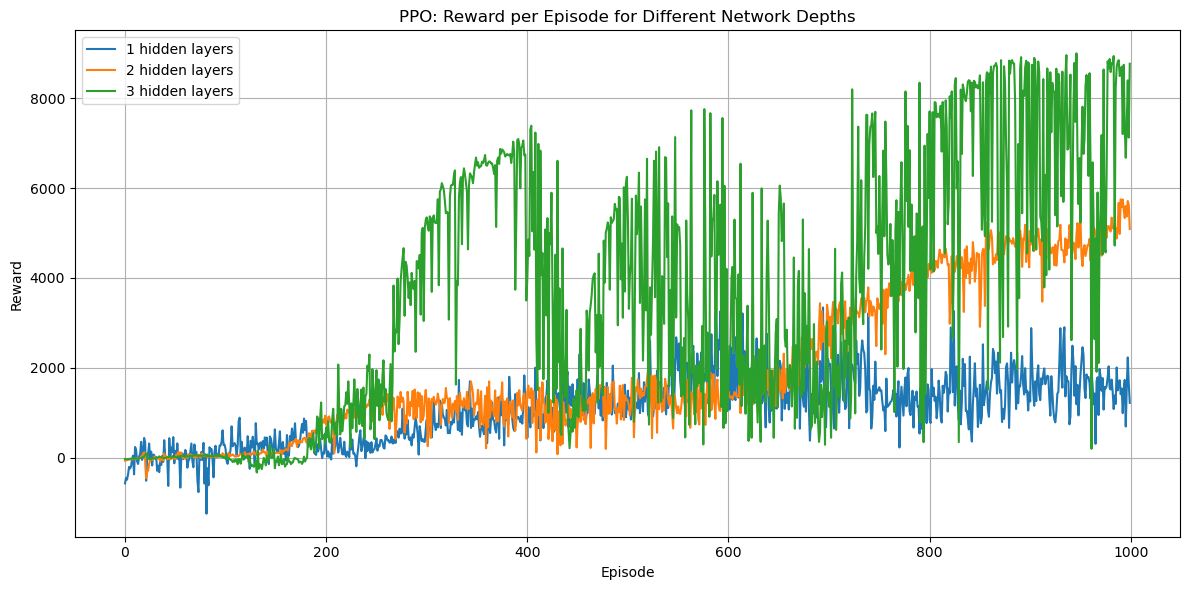

In [23]:
# Best Optuna Params
best_params = {
    'lr': 0.0002926525471462949,
    'clip_epsilon': 0.2887539178508336,
    'gamma': 0.9621068731332175,
    'gae_lambda': 0.9795635869430831,
    'entropy_coef': 0.00046370805629906693,
    'vf_coef': 0.3046357524745881,
    'k_epochs': 5,
    'hidden_size': 64
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_rewards = {}

# Run for 1, 2, and 3 hidden layers
for num_layers in [1,2,3]:
    print(f"\n--- Running PPO with {num_layers} hidden layers ---")
    rewards = run_experiment(num_layers, best_params, device)
    all_rewards[num_layers] = rewards

# Plotting
plt.figure(figsize=(12, 6))
for num_layers, rewards in all_rewards.items():
    plt.plot(rewards, label=f"{num_layers} hidden layers")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PPO: Reward per Episode for Different Network Depths")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


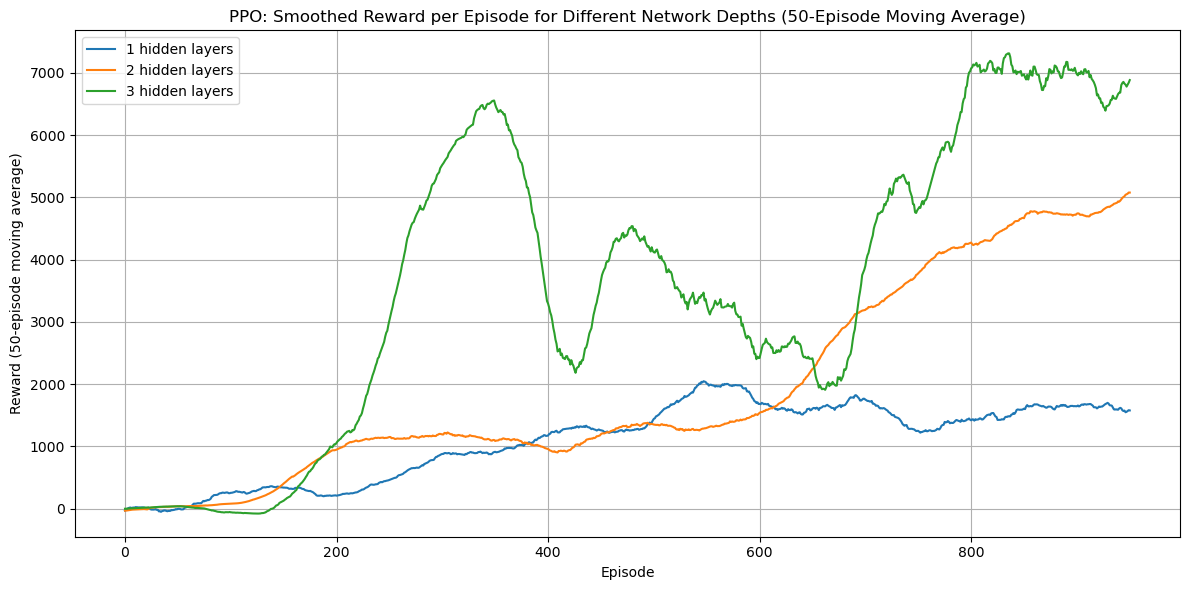

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def get_moving_averages(all_rewards, window_size=50):
    moving_avg_rewards = {}
    for num_layers, rewards in all_rewards.items():
        rewards_array = np.array(rewards)
        if len(rewards_array) < window_size:
            moving_avg = rewards_array  # not enough data to smooth
        else:
            moving_avg = np.convolve(rewards_array, np.ones(window_size)/window_size, mode='valid')
        moving_avg_rewards[num_layers] = moving_avg
    return moving_avg_rewards

# Compute moving averages
smoothed_rewards = get_moving_averages(all_rewards, window_size=50)

# Plotting
plt.figure(figsize=(12, 6))
for num_layers, rewards in smoothed_rewards.items():
    plt.plot(rewards, label=f"{num_layers} hidden layers")
plt.xlabel("Episode")
plt.ylabel("Reward (50-episode moving average)")
plt.title("PPO: Smoothed Reward per Episode for Different Network Depths (50-Episode Moving Average)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
